**Please Note**

This notebook contains a lot of things that you probably shouldn't do when working with Pandas or Python more generally. Eventually, it will get reworked into something less offensive. 

## Imports and Setup

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import string

In [2]:
from collections import Counter
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

In [3]:
from src.paths import INTERIM_CORPUS

In [4]:
%config InlineBackend.figure_format = "retina"
%matplotlib inline

## Ingestion and Initial Inspection of the Data

### Number of files to collect

I began by converting the raw `json` into .csv format with `make transform` (probably should have just read directly from the json). This left us with the following number of csv files to import.  

In [5]:
Counter(p.suffix for p in INTERIM_CORPUS.glob('*.csv'))

Counter({'.csv': 395})

### Import

Next, I'll import all the files. (Note: probably shouldn't read the entire dataset in this way, but only things we need. Also, try to get `dask` to work for this process). 

In [6]:
df = pd.concat([
    pd.read_csv(
        f, 
        encoding='utf-8',
        parse_dates=['parsed_created_at'])
    for f in INTERIM_CORPUS.glob('*.csv')
], ignore_index=True)  # otherwise, index is weird

Let's save that to pickle for perhaps faster loading in the future?

In [ ]:
#df.to_pickle(INTERIM_CORPUS / "pickled_tweets.pkl")

In the future, should be able to read the dataframe as follows:

In [ ]:
#df = pd.read_pickle(INTERIM_CORPUS / "pickled_tweets.pkl")

### Data Inspection

Basic checks, with first and last five rows. 

In [7]:
# first five rows
df.head()

,id,tweet_url,created_at,parsed_created_at,user_screen_name,text,tweet_type,coordinates,place,hashtags,...,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_statuses_count,user_time_zone,user_urls,user_verified
0,1113445021917880320,https://twitter.com/LondonLiberal/status/11134...,Wed Apr 03 14:15:54 +0000 2019,2019-04-03 14:15:54+00:00,LondonLiberal,If you only watch one video today let it be th...,retweet,NaN,NaN,Brexit,...,6035,89,397,0,NaN,LondonLiberal 🇬🇧,5750,NaN,NaN,False
1,1113445023033458689,https://twitter.com/GeoffreyClewes/status/1113...,Wed Apr 03 14:15:54 +0000 2019,2019-04-03 14:15:54+00:00,GeoffreyClewes,Latest statement from me on #Brexit developmen...,retweet,NaN,NaN,Brexit Cornwall,...,635,253,340,10,"Bolton, England",Geoffrey Clewes,81631,NaN,NaN,False
2,1113445026820972549,https://twitter.com/villedemarcq/status/111344...,Wed Apr 03 14:15:55 +0000 2019,2019-04-03 14:15:55+00:00,villedemarcq,#Brexit : l’Union Européenne la plus proche du...,retweet,NaN,NaN,Brexit,...,3154,1273,433,52,"Marcq-en-Baroeul, France",Marcq-en-Baroeul,5194,NaN,http://www.marcq-en-baroeul.org,False
3,1113445028440023041,https://twitter.com/twobirdshealth/status/1113...,Wed Apr 03 14:15:56 +0000 2019,2019-04-03 14:15:56+00:00,twobirdshealth,"""Have we left the EU yet?"" ""How will the #UKIP...",retweet,NaN,NaN,UKIPO Brexit,...,60,226,191,9,Worldwide,Bird & Bird Health,528,NaN,http://www.twobirds.com/en/sectors/life-scienc...,False
4,1113445030268624897,https://twitter.com/ChuckDalldorf/status/11134...,Wed Apr 03 14:15:56 +0000 2019,2019-04-03 14:15:56+00:00,ChuckDalldorf,"Macron, Irish PM urge UK to propose alternativ...",original,NaN,NaN,Brexit UK EU Scotland NI Wales England Ireland...,...,56367,4093,4762,859,NaN,Chuck Dalldorf,220712,NaN,NaN,False


In [8]:
# last five rows
df.tail()

,id,tweet_url,created_at,parsed_created_at,user_screen_name,text,tweet_type,coordinates,place,hashtags,...,user_favourites_count,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_statuses_count,user_time_zone,user_urls,user_verified
3941648,1107073766461489152,https://twitter.com/chrismayes/status/11070737...,Sun Mar 17 00:18:49 +0000 2019,2019-03-17 00:18:49+00:00,chrismayes,I have never been invited by the mainstream me...,retweet,NaN,NaN,Brexit,...,9376,937,1355,8,Newcastle Upon Tyne,#stopbrexitsavebritain #FBPE,7379,NaN,NaN,False
3941649,1107073430547910657,https://twitter.com/DjRedBroad/status/11070734...,Sun Mar 17 00:17:28 +0000 2019,2019-03-17 00:17:28+00:00,DjRedBroad,This must rank as one of the saddest photos I ...,retweet,NaN,NaN,MarchtoLeave Brexit GammonBallRun,...,34902,3421,4939,16,Marina del Rey,Red Broad #FBPE 🇪🇺 #PeoplesVote 👍,31519,NaN,http://www.chill2evolve.com,False
3941650,1107073639134818304,https://twitter.com/roger3cav/status/110707363...,Sun Mar 17 00:18:18 +0000 2019,2019-03-17 00:18:18+00:00,roger3cav,Struggling to understand the twists and turns ...,retweet,NaN,NaN,Brexit Insiders,...,146226,681,197,44,Mid North Coast Australia,Roger Mika💧,85149,NaN,NaN,False
3941651,1107073594214019072,https://twitter.com/j00liju/status/11070735942...,Sun Mar 17 00:18:07 +0000 2019,2019-03-17 00:18:07+00:00,j00liju,Uncomfortable truth: The more the Left retreat...,retweet,NaN,NaN,Brexit,...,11065,248,241,1,bournemouth,julie,4211,NaN,NaN,False
3941652,1107073754688045057,https://twitter.com/Dstubbs07912787/status/110...,Sun Mar 17 00:18:46 +0000 2019,2019-03-17 00:18:46+00:00,Dstubbs07912787,This is why no Labour MP or Tory “moderate” sh...,retweet,NaN,NaN,Brexitshambles Brexit FinalSay PeoplesVote,...,18758,82,134,0,"North East, England",Dstubbs,13071,NaN,NaN,False


**Variables/Column names**

In [9]:
df.columns

Index(['id', 'tweet_url', 'created_at', 'parsed_created_at',
       'user_screen_name', 'text', 'tweet_type', 'coordinates', 'place',
       'hashtags', 'media', 'urls', 'favorite_count',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_user_id', 'lang', 'possibly_sensitive', 'retweet_count',
       'retweet_or_quote_id', 'retweet_or_quote_screen_name',
       'retweet_or_quote_user_id', 'source', 'user_id', 'user_created_at',
       'user_default_profile_image', 'user_description',
       'user_favourites_count', 'user_followers_count', 'user_friends_count',
       'user_listed_count', 'user_location', 'user_name',
       'user_statuses_count', 'user_time_zone', 'user_urls', 'user_verified'],
      dtype='object')

**Variable/Column types**

In [10]:
df.dtypes

id                                            int64
tweet_url                                    object
created_at                                   object
parsed_created_at               datetime64[ns, UTC]
user_screen_name                             object
text                                         object
tweet_type                                   object
coordinates                                  object
place                                        object
hashtags                                     object
media                                        object
urls                                         object
favorite_count                                int64
in_reply_to_screen_name                      object
in_reply_to_status_id                       float64
in_reply_to_user_id                         float64
lang                                         object
possibly_sensitive                           object
retweet_count                                 int64
retweet_or_q

## Basic Stats

In [11]:
df.shape

(3941653, 37)

In [12]:
print(f'There are {df.shape[0]} rows (observations) and {df.shape[1]} columns (variables)')

There are 3941653 rows (observations) and 37 columns (variables)


### Tweet Types

In [13]:
types = (df
         .tweet_type
         .value_counts()
        )
print(types)

retweet     2837139
original     699480
reply        227365
quote        177669
Name: tweet_type, dtype: int64


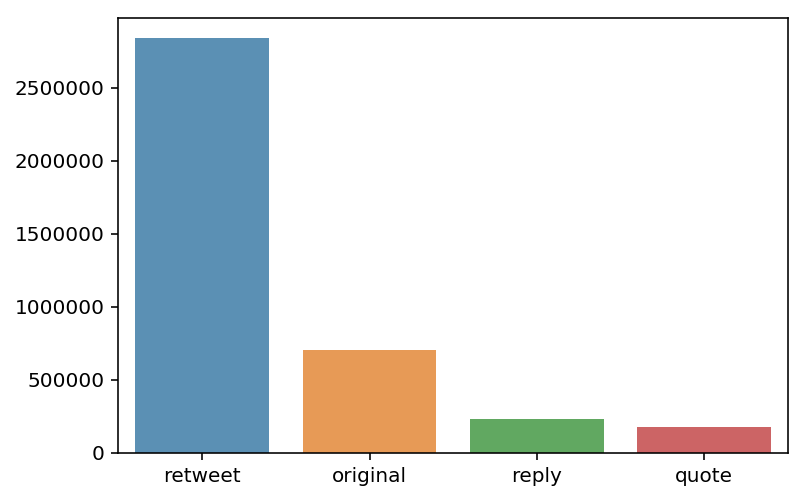

In [14]:
_ = sns.barplot(x=types.index, y=types.values, alpha=0.8)

### Tweet Types by Day

In [15]:
df.set_index('parsed_created_at', inplace=True)

In [16]:
df['day'] = df.index.date

In [17]:
daily_plot = df.groupby(['day', 'tweet_type']).size().unstack()

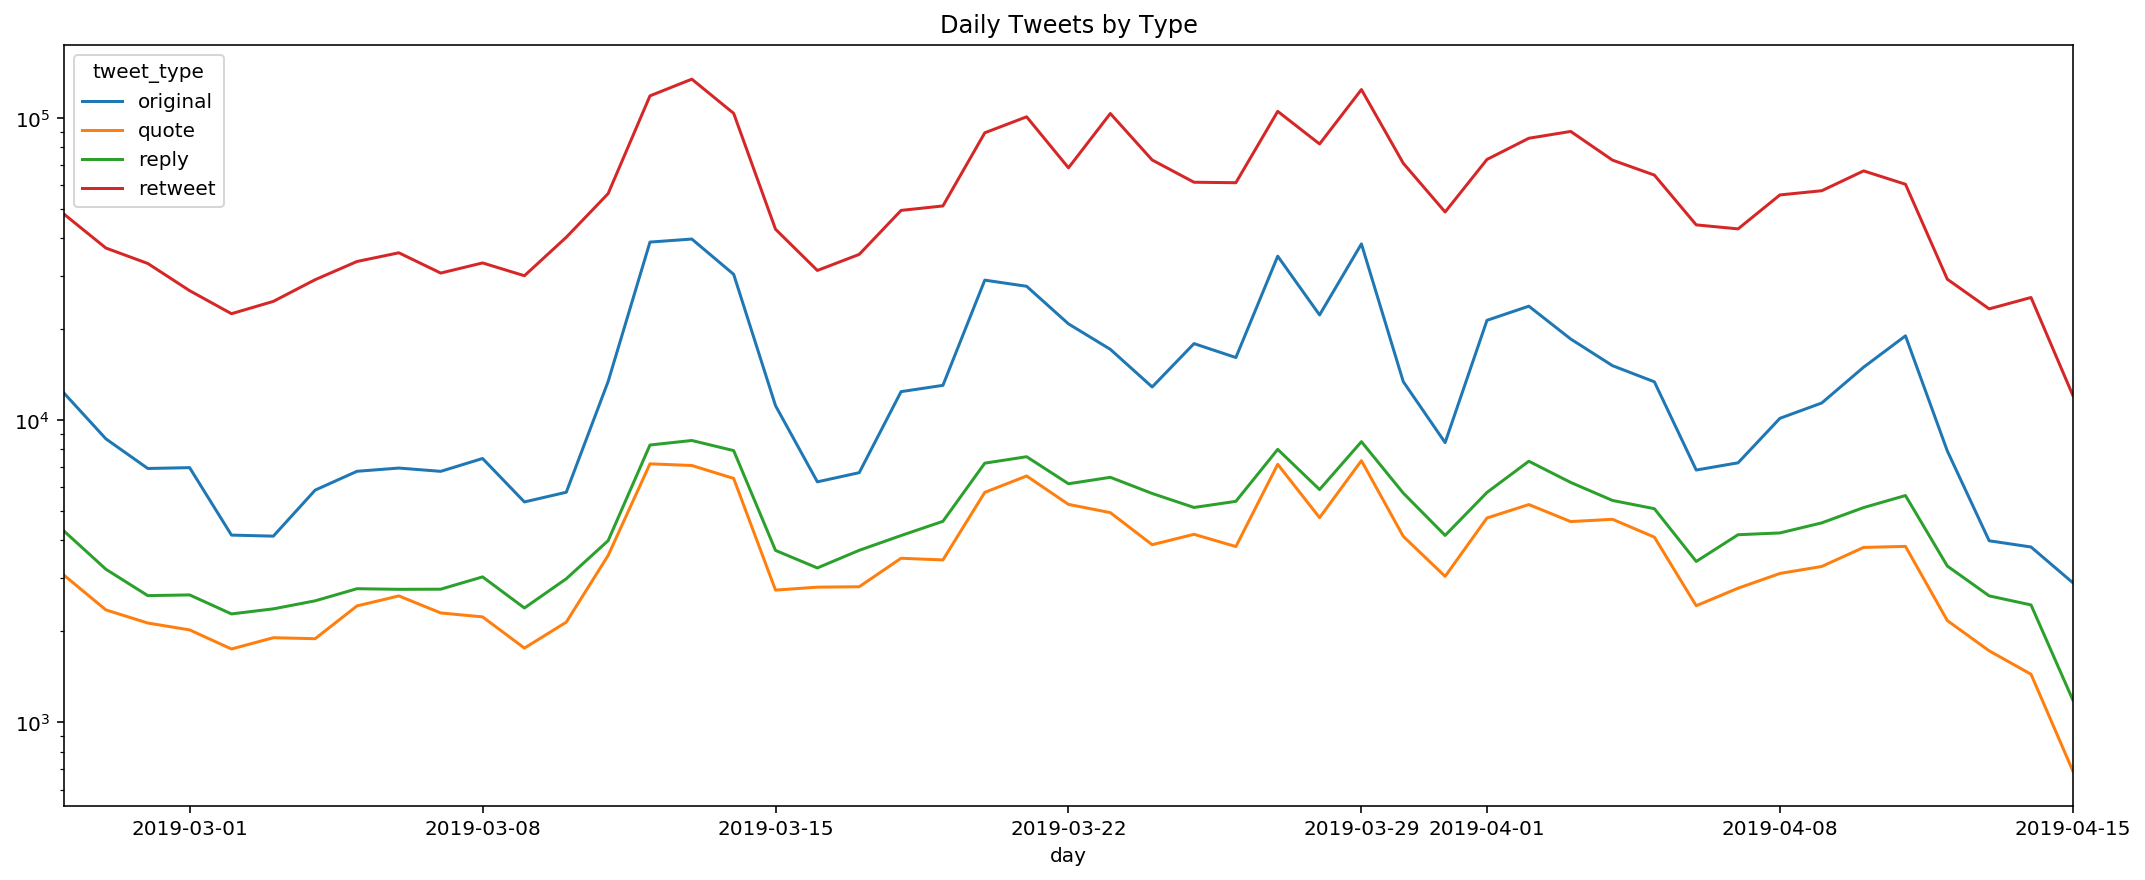

In [18]:
_ = daily_plot.plot(title='Daily Tweets by Type', logy=True, figsize=(18, 7))

Note that the y-axis is on the log scale. (Maybe a rolling mean would also be nice). 

### Users

In [19]:
# number of unique tweeters
df['user_screen_name'].nunique()

757930

In [20]:
print(f"There are {df['user_screen_name'].nunique()} distinct users.")

There are 757930 distinct users.


In [21]:
tweeps = (df.groupby(['user_screen_name'])
         .count()
         .reset_index())

In [22]:
tweeps = (tweeps
         .sort_values(by='text')
         .tail(10))

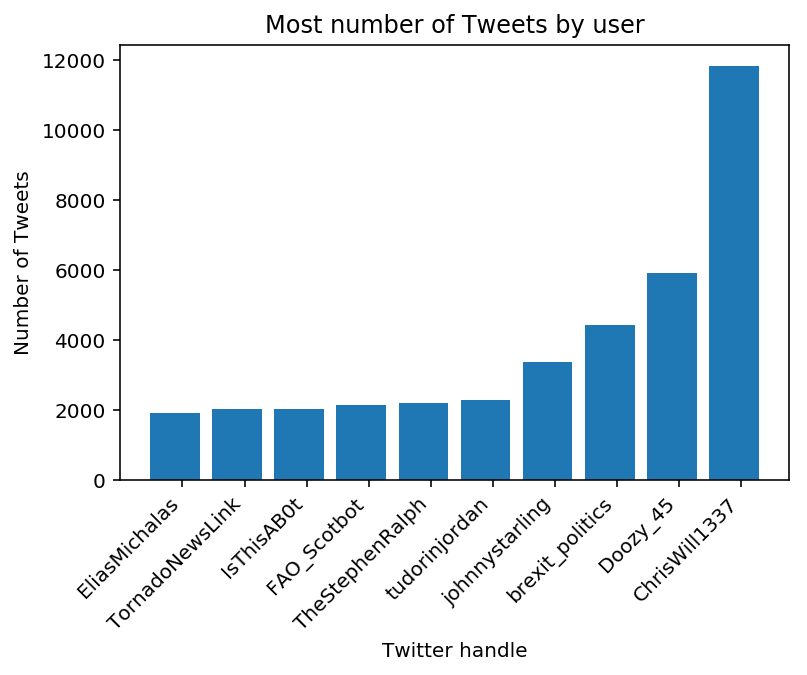

In [23]:
x = tweeps['user_screen_name']
y = tweeps['text']
plt.xlabel('Twitter handle')
plt.ylabel('Number of Tweets')
plt.title('Most number of Tweets by user')
h=plt.bar(range(10), y, label='Most Tweets by user')
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
_ = plt.xticks(xticks_pos, x, ha='right', rotation=45)

### Languages

In [24]:
df['lang'].nunique()

57

In [25]:
print(f"There are {df['lang'].nunique()} distinct languages (including undetermined ones)")

There are 57 distinct languages (including undetermined ones)


In [26]:
languages = (df
             .lang
             .value_counts())

languages.head(10)

en     3462381
fr      126566
de       89364
und      69011
es       64391
it       48253
nl       23524
pl       10048
fi        5349
tr        4751
Name: lang, dtype: int64

#### Undetermined languages

Let's take a look at languages that Twitter didn't classify

In [27]:
# create a mask for filtering
und = df['lang'] == 'und'

In [28]:
df[und]['text'].head(20)

parsed_created_at
2019-04-03 14:16:21+00:00    @nicholaswatt @TeresaWeath @BBCNewsnight Or #B...
2019-04-03 14:15:43+00:00    #JacobReesMogg      #AliceWeidel         #Brex...
2019-04-03 14:14:04+00:00                      #Brexit https://t.co/YZ6VOTYPa2
2019-04-03 14:12:31+00:00    #Brexit #BrexitBetrayal #VoteUKIP #VoteThemOut...
2019-04-03 14:12:46+00:00    @guyverhofstadt #brexit now! https://t.co/gS71...
2019-04-03 14:11:10+00:00    Pošlite už ten bloody #brexit do histórie! Píš...
2019-04-03 14:11:22+00:00    My @standardnews #cartoon #Brexit #illustratio...
2019-04-03 14:11:57+00:00                      #Brexit https://t.co/Ohmwvg7uEb
2019-04-03 14:08:52+00:00                      #Brexit https://t.co/UeeLeDbzqd
2019-04-03 14:09:03+00:00              #brexit #Tories https://t.co/jkdlKaEpqk
2019-04-03 14:06:27+00:00    #Brexit #BrexitBetrayal #VoteUKIP #VoteThemOut...
2019-04-03 14:04:47+00:00    #Brexit @theresa_may @jeremycorbyn @JunckerEU ...
2019-04-03 14:04:55+00:00    #Brex

Looks like these are tweets that consist only of hashtags, mentions, urls, etc. Should try to examine further. 

### Hashtags

We'll get the hashtags from the text to make sure we get all of them, as the `hashtag` field isn't always reliable. 

In [29]:
hashtags = (df
            .text
            .str.extractall(r'(\#\w+)')[0]
            .str.lower()
            .value_counts()
           )

In [30]:
hashtags.nunique()

1249

We're going to skip `#brexit`, since it was the search term.

In [31]:
hashtags = hashtags[1:11,]

In [32]:
hashtags

#peoplesvote         358471
#eu                  151379
#revokearticle50     149562
#finalsay             76421
#brexitshambles       72277
#nodeal               71679
#peoplesvotemarch     69342
#fbpe                 66142
#putittothepeople     64150
#uk                   61349
Name: 0, dtype: int64

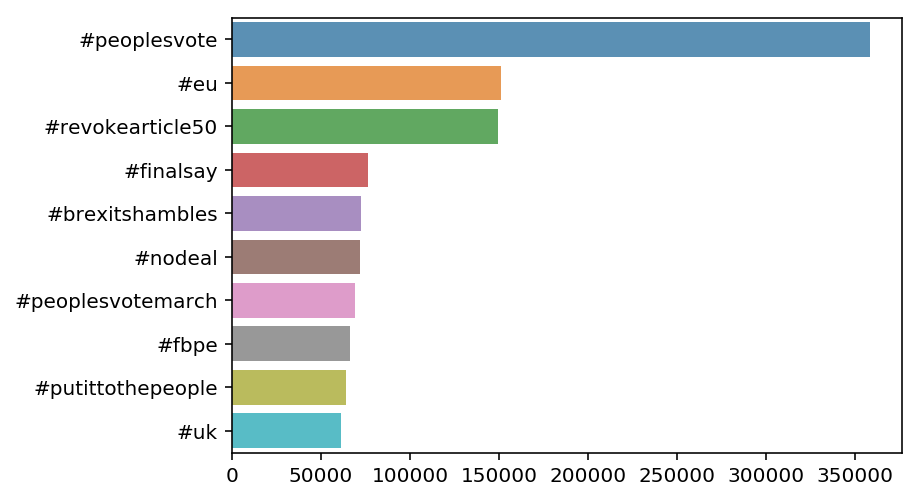

In [33]:
_ = sns.barplot(x=hashtags.values, y=hashtags.index, alpha=0.8)

### Mentions

In [34]:
mentions = (df
            .text
            .str.extractall(r'(@[\w_]+)')[0]
            .str.lower()
            .value_counts()
)

In [35]:
mentions = mentions[:10,]

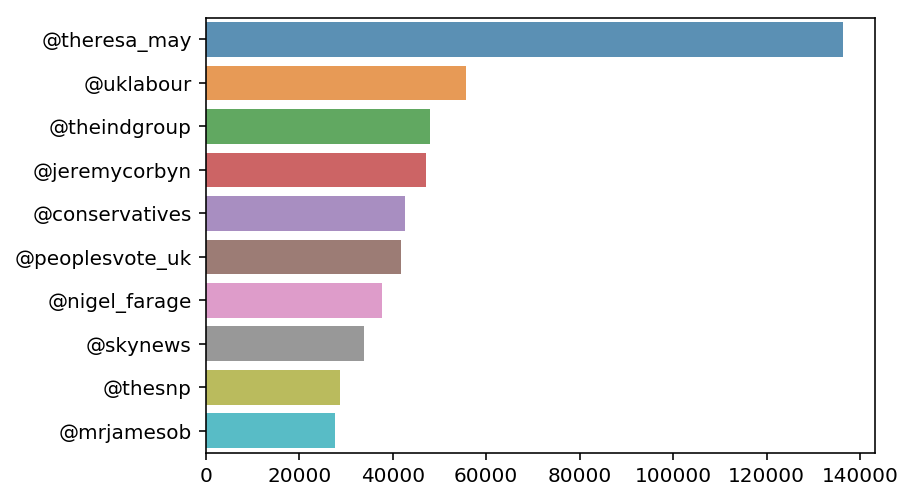

In [36]:
_ = sns.barplot(x=mentions.values, y=mentions.index, alpha=0.8)

### Wordcloud

I have my doubts about how informative wordclouds actually are, but maybe they work as art.

For this exercise, we'll just use tweets that have been identified as being in English.

In [37]:
english_df = df[df.lang == 'en']

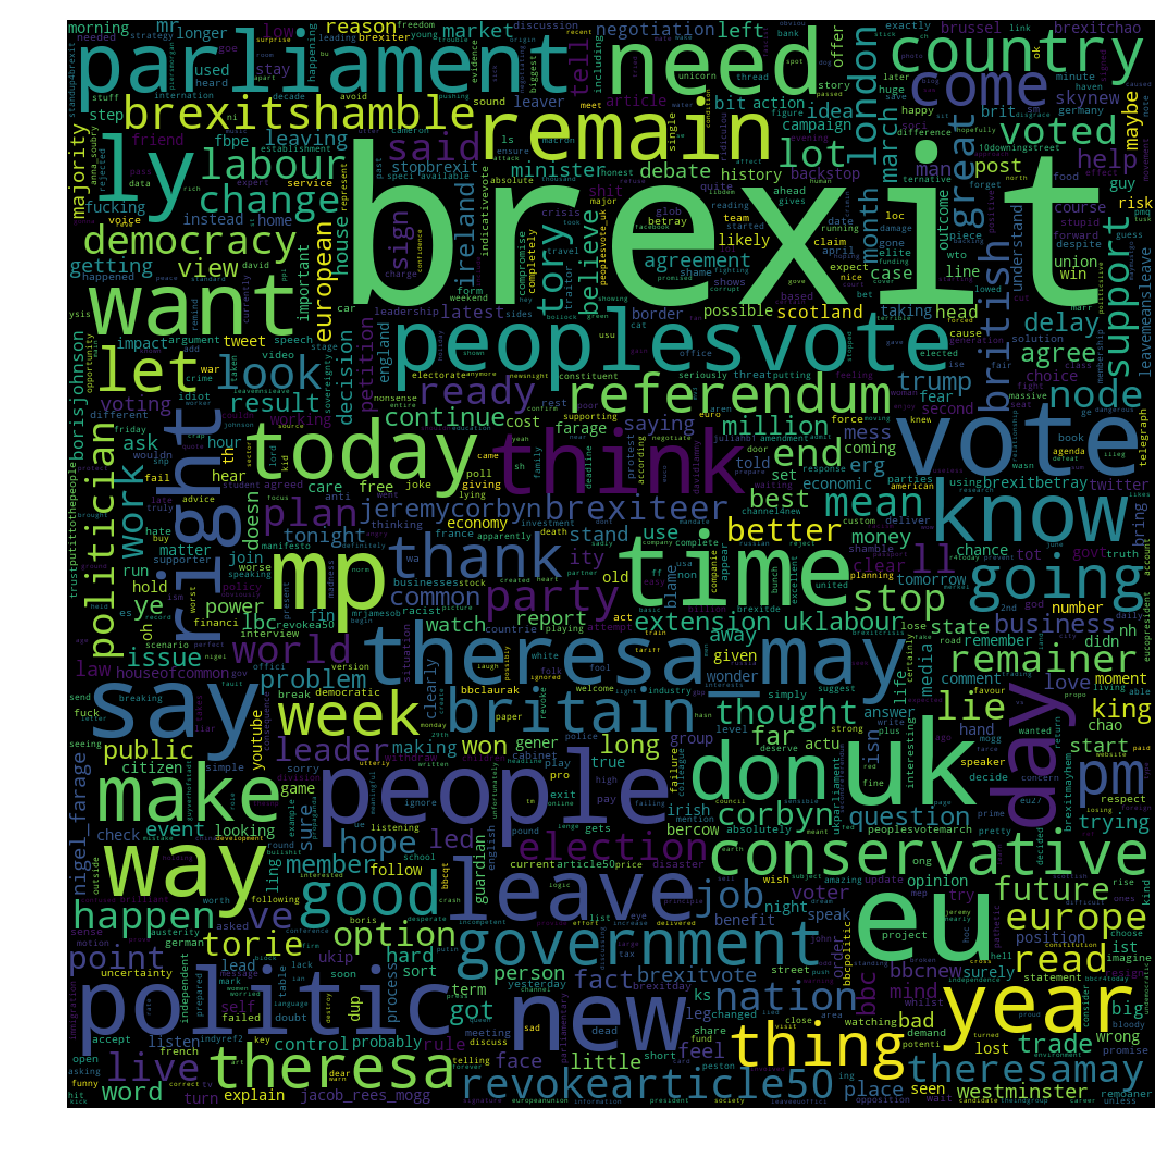

In [38]:
junk = re.compile("al|RT|\n|&.*?;|http[s](?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+)*")
tweets = [junk.sub(" ", t) for t in english_df.text]

vec = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_df=.5)
tfv = vec.fit_transform(tweets)

terms = vec.get_feature_names()
wc = WordCloud(height=1000, width=1000, max_words=1000).generate(" ".join(terms))

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off")
plt.show()